# Focusing on the Galaxy

___________

## Importing all python libraries

In [1]:
import numpy as np
from astropy.io import fits
import matplotlib.pyplot as plt
from ROHSApy import ROHSA
from scipy.optimize import curve_fit
import random

# For the mosaic of the maps
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib import ticker
from matplotlib.ticker import ScalarFormatter

## Download the cube

The first thing I need to do is download the data cube. I went to the address: https://www.cita.utoronto.ca/GHIGLS/ to download the data cube. The designated region I am working with is the SPIDER region. 

In [2]:
#!wget https://www.cita.utoronto.ca/GHIGLS/FITS/GHIGLS_SPIDER_Tb.fits

Here, I also install ROHSApy

In [3]:
#!pip install ROHSApy

## Load the cube

In [4]:
# Now I need to load the data cube that I collected in the above step.
fitsname = "GHIGLS_SPIDER_Tb.fits"
hdu = fits.open(fitsname)
hdr = hdu[0].header
cube = hdu[0].data[0][:,:,:]
# In the PPV cube, there are 3 axes (Representing the three spaces in the list).
# The first is the velocity axis. The others represent the position coordinates, x and y.

In [5]:
hdr["NAXIS3"] = 350 # The range of subvel (end_subvel - start_subvel)
hdr["CRPIX3"] -= 200 # This is to fix the position of the peaks to have the right index and velocity

In order to get the axis to be in units of velocity, need this function which converts pixel units to velocity (km/s)

In [6]:
def spec_2_velocity(CRVAL, CDELT, CRPIX, index):
    '''
    Description: 
        This function takes in the parameters from the header and adjusts the \
        velocity range so that is centers at zero (based on the reference). 
    
    Parameters:
        CRVAL - The value of the reference velocity - float
        CDELT - The value of the channel spacing - float
        CRPIX - The value of the pixel where CRVAL occurs - float
    
    Returns:
        This function returns the adjusted velocity list - list
    '''
    vel = [(CRVAL + CDELT * (index[i] - CRPIX)) for i in range(len(index))]
    # Puts in units of km/s
    
    return vel

In [7]:
index_arr = np.arange(cube.shape[0])

cdelt3 = hdr["CDELT3"]/1000. #This allows it to be in units of km/s rather than m/s
crpix3 = hdr["CRPIX3"]
crval3 = hdr["CRVAL3"]/1000. #This allows it to be in units of km/s rather than m/s

vel = np.array(spec_2_velocity(crval3,cdelt3,crpix3,index_arr))

## Getting ROHSA to analyze a region

In [8]:
!git clone https://github.com/antoinemarchal/ROHSA.git ROHSA
import os
os.chdir('ROHSA/src')
!make
os.chdir('../../')

fatal: destination path 'ROHSA' already exists and is not an empty directory.
gfortran blas.o lbfgsb.o linpack.o timer.o mod_constants.o mod_convert.o mod_inout.o mod_array.o mod_optimize.o mod_optimize_lym.o mod_minimize.o mod_functions.o mod_start.o mod_rohsa.o main.o -lm -g -O2  -o ROHSA


## Define the limits and the region

In [9]:
# Approximate center position of the spider leg is y=130, x=140 (right most part)
# Since we want a square of 64 x 64, we need to go 32 up and 32 down with respect to both x and y
galaxy_cent_x = 20 ; galaxy_cent_y = 150

lim = 16
galaxy_x_left = galaxy_cent_x-lim; galaxy_x_right = galaxy_cent_x+lim
galaxy_y_left = galaxy_cent_y-lim; galaxy_y_right = galaxy_cent_y+lim

idx_limit_left = 200; idx_limit_right = 550

subvel_galaxy = vel[:idx_limit_right-idx_limit_left]
subcube_galaxy = cube[idx_limit_left:idx_limit_right, galaxy_y_left:galaxy_y_right, galaxy_x_left:galaxy_x_right]

I can first try to plot a single spectrum of the center of the leg:

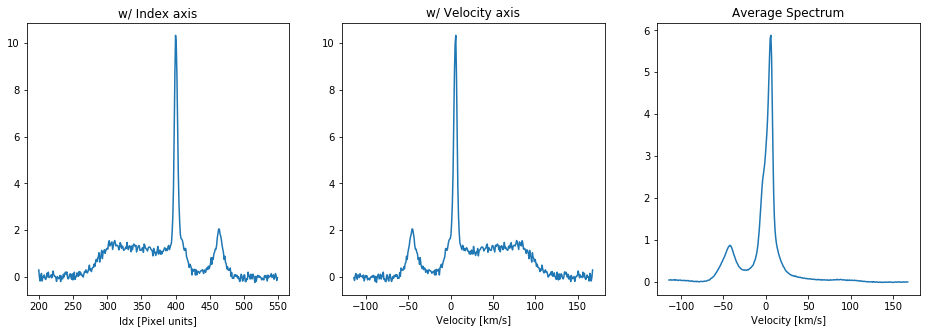

In [10]:
plt.figure(figsize=(16,5))
plt.subplot(1,3,1)
plt.xlabel("Idx [Pixel units]")
plt.title("w/ Index axis")
plt.plot(index_arr[idx_limit_left:idx_limit_right], cube[idx_limit_left:idx_limit_right, galaxy_cent_y, galaxy_cent_x])

plt.subplot(1,3,2)
plt.title("w/ Velocity axis")
plt.xlabel("Velocity [km/s]")
plt.plot(subvel_galaxy,  cube[idx_limit_left:idx_limit_right, galaxy_cent_y, galaxy_cent_x])

plt.subplot(1,3,3)
avg_subcube_galaxy = np.mean(subcube_galaxy, (1,2))
plt.title("Average Spectrum")
plt.plot(subvel_galaxy, avg_subcube_galaxy)
plt.xlabel("Velocity [km/s]")

plt.show()

## Taking a closer look at the Galaxy

Here, I can plot the whole spider from the original data, as well as the zoomed in plot of the galaxy region to highlight this unique feature in the data.

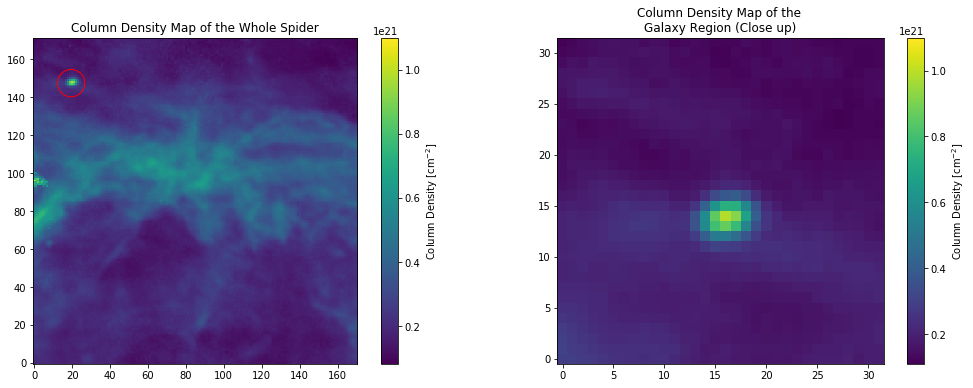

In [91]:
fig = plt.figure(figsize=(18,6))
plt.subplot(1,2,1) ; plt.title("Column Density Map of the Whole Spider")
plt.scatter(19.5, 147.5, s=750, facecolors='none', edgecolors='r')
plt.imshow(np.sum(cube, 0)*C*dv, origin='lower', vmax=1.1e21) ; plt.colorbar(label="Column Density [cm$^{-2}$]")
plt.subplot(1,2,2) ; plt.title("Column Density Map of the \nGalaxy Region (Close up)")
plt.imshow(np.sum(subcube_galaxy, 0)*C*dv, origin='lower', vmax=1.1e21) ; plt.colorbar(label="Column Density [cm$^{-2}$]")
plt.subplots_adjust(wspace=0.1)
fig.savefig("Close_up_on_galaxy.pdf", bbox_inches='tight')

From this point source, we can gather some information. One thing is that this point has a very large column density compared to the rest of the SPIDER. This could be a problem when analyzing the whole cube as this is not of interest when looking at the actual SPIDER. 

## Define ROHSA parameters

In [11]:
filename = "GHIGLS_SPIDER_Tb.dat" #@param
fileout = "GHIGLS_SPIDER_Tb_gauss_run_galaxy.dat" #@param
filename_parameters = "parameters_galaxy.txt"
filename_noise = ''
n_gauss = 18          #@param {type:"slider", min:1, max:12, step:1}                                                                                                                                                                                                                             
lambda_amp = 100 #@param {type:"slider", min:0, max:1000, step:1}
lambda_mu = 100       #@param {type:"slider", min:0, max:1000, step:1}
lambda_sig = 100      #@param {type:"slider", min:0, max:1000, step:1}
lambda_var_amp = 0.                                                                                                                                                                                                                                                           
lambda_var_mu = 0.                                                                                                                                                                                                                                                        
lambda_var_sig = 150   #@param {type:"slider", min:0, max:10000, step:1}                                                                                                                                                                                                                                                            
amp_fact_init = 0.66  # times max amplitude of additional Gaussian                                                                                                                                                                                                                                                          
sig_init = 4.         # dispersion of additional Gaussian                                                                                                                                                                                                                                                                   
init_option = 'mean'  # init ROHSA with the mean or the std spectrum                                                                                                                                                                                                                                                      
maxiter_init = 15000  # max iteration for L-BFGS-B alogorithm init mean                                                                                                                                                                                                                                        
maxiter = 400         #@param {type:"slider", min:1, max:800, step:1}                                                                                                                                                                                                                                                         
m = 10                # number of corrections used in the limited memory matrix                                                                                                                                                                                                                               
noise = ".false."     # if false - STD map computed by ROHSA with lstd and ustd                                                                                                                                                                                                           
regul = ".true."      # if true - activate regulation                                                                                                                                                                                                                                                                 
descent = ".true."    #@param [".true.", ".false."]                                                                                                                                                                                                                       
lstd = 1              #@param {type:"slider", min:1, max:400, step:1}                                                                                                                                                                                                                
ustd = 20             #@param {type:"slider", min:1, max:400, step:1}                                                                                                                                                                                                                 
iprint = -1           #@param ["-1", "0", "1"]                                                                                                                                                                                                                                                                                      
iprint_init = -1      # print option init                                              
save_grid = ".false." #@param [".true.", ".false."] 

core = ROHSA(subcube_galaxy, hdr=hdr)            
core.cube2dat(filename=filename)
core.gen_parameters(filename=filename, 
                    fileout=fileout,
                    filename_parameters=filename_parameters,
                    n_gauss=n_gauss,
                    lambda_amp=lambda_amp,
                    lambda_mu=lambda_mu,
                    lambda_sig=lambda_sig,
                    lambda_var_sig=lambda_var_sig,
                    maxiter=maxiter,
                    descent=descent,
                    lstd=lstd,
                    ustd=ustd,
                    iprint=iprint,
                    save_grid=save_grid)

Generate GHIGLS_SPIDER_Tb.dat file readable by fortran
Generate parameters_galaxy.txt file


In [12]:
# This allows us to run ROHSA on the data
# !./ROHSA/src/ROHSA parameters_galaxy.txt

## Getting the Gaussian parameters for the decomposition

In [13]:
# Some constants for the integrals:
dv = abs(cdelt3)
C = 1.82243e18

In [14]:
gaussian_galaxy = core.read_gaussian("GHIGLS_SPIDER_Tb_gauss_run_galaxy.dat")
params = core.physical_gaussian(gaussian_galaxy)

print("dim cube = " + str(gaussian_galaxy.shape))

model_galaxy = core.return_result_cube(gaussian=gaussian_galaxy)

# Physical Space
amplitude_galaxy = gaussian_galaxy[0::3]
position_galaxy = np.array(spec_2_velocity(crval3,cdelt3,crpix3,gaussian_galaxy[1::3]))
dispersion_galaxy = gaussian_galaxy[2::3]

# "Pixel" Space
amplitude_pix = gaussian_galaxy[0::3]
position_pix = gaussian_galaxy[1::3]
dispersion_pix = gaussian_galaxy[2::3] * dv

integral_galaxy = amplitude_galaxy * dispersion_galaxy * np.sqrt(2*np.pi) 

Opening data file
dim cube = (54, 32, 32)


In [15]:
NHI_map_galaxy = integral_galaxy * C  # *dv is included in dispersion

## Plot a spectrum

In [93]:
def plot_spect(x_pos, y_pos, vel, model, cube, gaussian, caption=""):
    fig = plt.figure(figsize=(8,6))
    plt.xlabel("$v$ [$km$ $s^{-1}$]")
    plt.ylabel("$T_{b}$ [$K$]")
    plt.plot(vel, cube, color='cornflowerblue',  label="data")
    plt.plot(vel, model , color='red', label="model")
    
    # To plot all the gaussians under the model and data:
    for i in range(n_gauss):
            plt.plot(vel, core.gauss(np.arange(len(vel)), \
                                              gaussian[0::3][i][y_pos,x_pos],\
                                              gaussian[1::3][i][y_pos,x_pos],\
                                              gaussian[2::3][i][y_pos,x_pos]), 'k')
    plt.legend()
    plt.show()
    fig.savefig(caption, bbox_inches="tight")

In [19]:
x_pos_galaxy = random.randint(0,32-4); y_pos_galaxy = random.randint(0,32-4)
print("x = ", x_pos_galaxy) ; print("y = ", y_pos_galaxy)

x =  2
y =  22


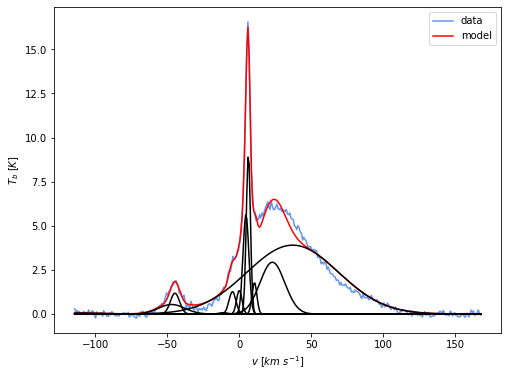

In [94]:
plot_spect(x_pos_galaxy, y_pos_galaxy, subvel_galaxy,\
           model_galaxy[:, y_pos_galaxy, x_pos_galaxy], subcube_galaxy[:, y_pos_galaxy, x_pos_galaxy],\
           gaussian_galaxy, "random_spectrum_galaxy.pdf")

## Find the value of $\chi^{2}$

In [42]:
stdev_galaxy = np.std(cube[5:25, 0, 0]) 
print("Std:", stdev_galaxy)

N_model_galaxy = model_galaxy[:,y_pos_galaxy,x_pos_galaxy] # Actual spectrum data
N_data_galaxy = subcube_galaxy[:,y_pos_galaxy,x_pos_galaxy] # Gaussian model 

r_galaxy = N_data_galaxy - N_model_galaxy

chisq_galaxy = np.sum((r_galaxy/stdev_galaxy)**2)
print("The value of chi squared is:", chisq_galaxy)

Std: 0.124584325
The value of chi squared is: 1280.7213931935332


From the value of $\chi^{2}$, this does not seem to be a good fit as the value is very high. Because of this unique point source has such a complex spectrum, it is hard for ROHSA to find the best parameters to fit it.

## Plot a mosaic of spectra

<Figure size 432x288 with 0 Axes>

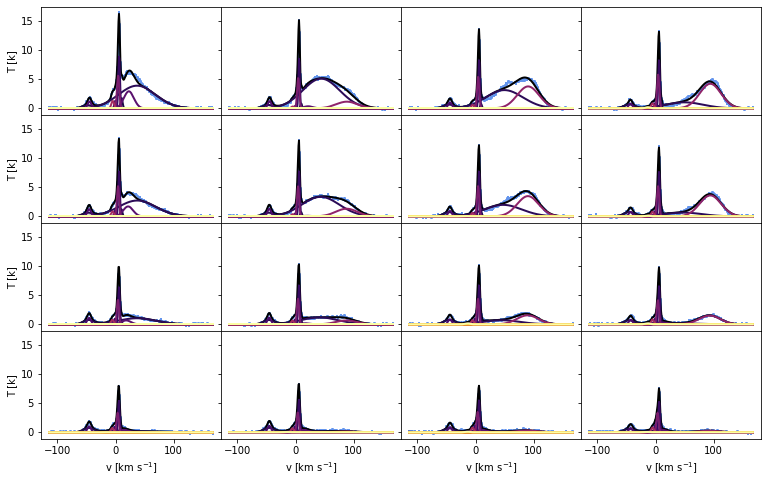

In [95]:
# Mosaic of the Spectra
pvalues = np.logspace(-1, 0, n_gauss)
pmin = pvalues[0]
pmax = pvalues[-1]

def norm(pval):
    return (pval - pmin) / float(pmax - pmin)

fig = plt.figure()
ny = 4; nx = 4
center_y = y_pos_galaxy; center_x = x_pos_galaxy
cb = "magenta"
cw = "crimson"
fig, axs = plt.subplots(nx, ny, sharex=True, sharey=True, figsize=(10.,6.))
fig.subplots_adjust(hspace=0, wspace=0, left=0, right=1, top=1, bottom=0)
for i in np.arange(ny):
    for j in np.arange(nx):
        axs[i][j].step(subvel_galaxy, subcube_galaxy[:,center_y+i,center_x+j], color='cornflowerblue', linewidth=2.)
        axs[i][j].plot(subvel_galaxy, model_galaxy[:,center_y+i,center_x+j], linestyle="-", linewidth=2., color="k")
        for k in range(n_gauss):
            axs[i][j].plot(subvel_galaxy, core.gauss(np.arange(len(subvel_galaxy)), gaussian_galaxy[0::3][k][center_y+i,center_x+j],
                                              gaussian_galaxy[1::3][k][center_y+i,center_x+j], gaussian_galaxy[2::3][k][center_y+i,center_x+j]),
                           linewidth=2., color=plt.cm.inferno(pvalues[k]))
        if j == 0: axs[i][j].set_ylabel(r'T [k]')
        axs[i][j].set_xlabel(r'v [km s$^{-1}$]')
fig.savefig("Mosaic_of_Spectra_galaxy.pdf", bbox_inches='tight')
#plt.savefig("plot/" + 'mosaic_spectra_all.png', format='png', bbox_inches='tight', pad_inches=0.02)

## Plot maps of the LVC and IVC to see WNM and CNM

In [26]:
# find the Gaussians that represent CNM and WNM
CNM_idx = np.where(np.median(dispersion_galaxy, (1,2)) < 5.)[0].tolist()
WNM_idx = np.where(np.median(dispersion_galaxy, (1,2)) > 5.)[0].tolist()

# Find the Gaussians that represent the LVC and IVC
LVC_idx = np.where(np.median(position_galaxy, (1,2)) > -25)[0].tolist()
IVC_idx = np.where(np.median(position_galaxy, (1,2)) < -25)[0].tolist()

CNM idx: [1, 4, 5, 6, 9, 11, 12, 13, 14, 15, 16] 

WNM idx: [0, 2, 3, 7, 8, 10, 17] 

LVC idx: [0, 1, 3, 4, 5, 7, 9, 10, 11, 12, 13, 14, 15, 16, 17] 

IVC idx: [2, 6, 8]


In [27]:
model_CNM = core.return_result_cube(ampfield=np.array(amplitude_pix)[CNM_idx],\
                                    pixfield=np.array(position_pix)[CNM_idx], sigfield=np.array(dispersion_pix)[CNM_idx])

model_WNM = core.return_result_cube(ampfield=np.array(amplitude_pix)[WNM_idx], \
                                    pixfield=np.array(position_pix)[WNM_idx], sigfield=np.array(dispersion_pix)[WNM_idx])

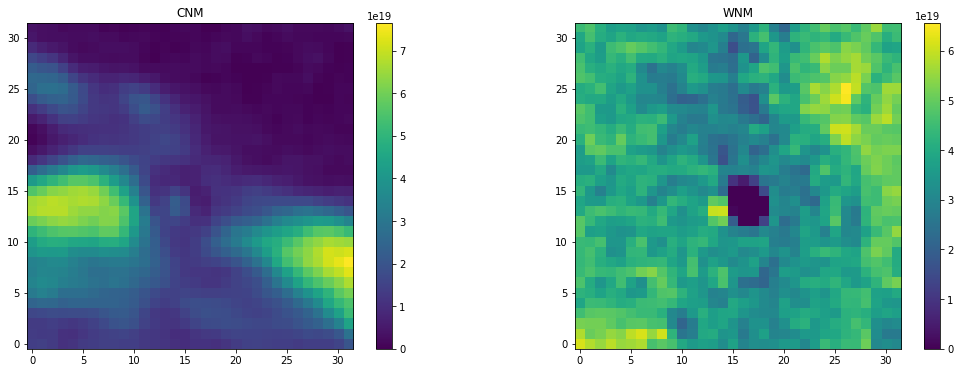

In [96]:
NHI_map_galaxy_CNM = NHI_map_galaxy[CNM_idx]
NHI_map_galaxy_WNM = NHI_map_galaxy[WNM_idx]

fig = plt.figure(figsize=(18,6))

plt.subplot(1,2,1) ; plt.title("CNM")
plt.imshow(NHI_map_galaxy_CNM[0], origin="lower")
plt.colorbar()

plt.subplot(1,2,2) ; plt.title("WNM")
plt.imshow(NHI_map_galaxy_WNM[0], origin="lower")
plt.colorbar()
plt.subplots_adjust(wspace=0.2); plt.show()

fig.savefig("Plots_of_phase_maps_LVC_and_IVC.pdf", bbox_inches='tight')

####  Summing over every pixel, looking at all gaussians per pixel

In [29]:
for i in range(subcube_galaxy.shape[1]):
    for j in range(subcube_galaxy.shape[2]):
    
        integ_LVC_CNM = np.zeros((subcube_galaxy.shape[1], subcube_galaxy.shape[2]))
        integ_LVC_WNM = np.zeros((subcube_galaxy.shape[1], subcube_galaxy.shape[2]))
        integ_IVC_CNM = np.zeros((subcube_galaxy.shape[1], subcube_galaxy.shape[2]))
        integ_IVC_WNM = np.zeros((subcube_galaxy.shape[1], subcube_galaxy.shape[2]))
        
        for n in range(n_gauss):
            # Check the dispersion (sigma) of the gaussian and the position (velocity)
            
            # Check if LVC (velocity cut-off is -30 km/s)
            if position_galaxy[n][i][j] > -30:
                
                # Check if CNM
                if dispersion_galaxy[n][i][j] < 5.:
                    integ_LVC_CNM = integ_LVC_CNM + integral_galaxy[n]
                    
                # Check if WNM
                elif dispersion_galaxy[n][i][j] > 5.:
                    integ_LVC_WNM = integ_LVC_WNM + integral_galaxy[n]
                  
                
            # Check if IVC (velocity cut-off is -30 km/s)
            if position_galaxy[n][i][j] < -30:
                
                # Check if CNM
                if dispersion_galaxy[n][i][j] < 5.:
                    integ_IVC_CNM = integ_IVC_CNM + integral_galaxy[n]
                    
                # Check if WNM
                elif dispersion_galaxy[n][i][j] > 5.:
                    integ_IVC_WNM = integ_IVC_WNM + integral_galaxy[n]

Now, I can produce maps of each of these cases:

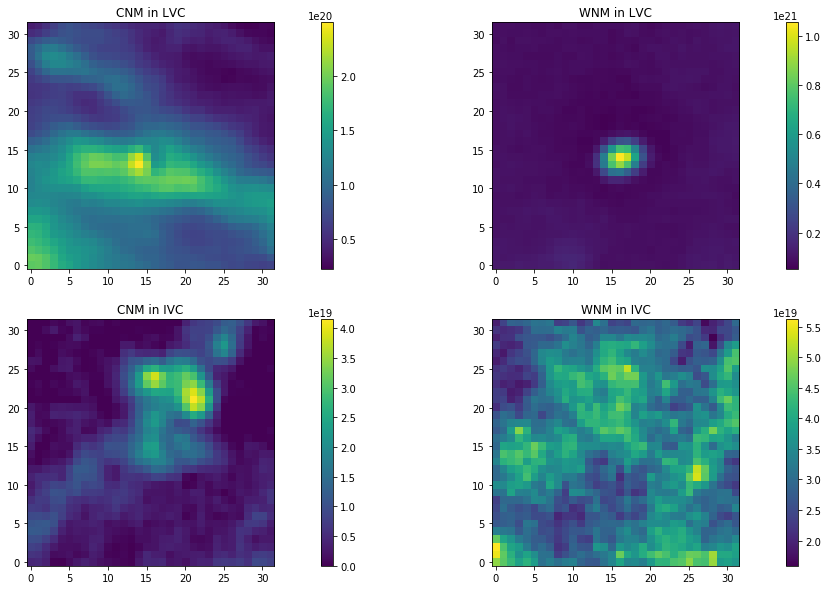

In [89]:
# Can plot the column density maps of each region
plt.figure(figsize=(25,10))

plt.subplot(2,2,1); plt.title("CNM in LVC")
plt.imshow(integ_LVC_CNM * C, origin="lower")
plt.colorbar()

plt.subplot(2,2,2); plt.title("WNM in LVC")
plt.imshow(integ_LVC_WNM * C, origin="lower")
plt.colorbar()

plt.subplot(2,2,3); plt.title("CNM in IVC")
plt.imshow(integ_IVC_CNM * C, origin="lower")
plt.colorbar()

plt.subplot(2,2,4); plt.title("WNM in IVC")
plt.imshow(integ_IVC_WNM * C, origin="lower")
plt.colorbar()

plt.subplots_adjust(wspace=-0.5); plt.show()

## 2D Histogram

The 2-D histogram can plot each gaussian depending on its dispersion and position. The clumps of pixels represent one gaussian.

In [31]:
iddx = np.argsort(np.mean(position_galaxy, axis=(1,2)))
field = [NHI_map_galaxy[idd] for idd in iddx]
vfield = [position_galaxy[idd] for idd in iddx]
ampfield = [amplitude_galaxy[idd] for idd in iddx]
sigfield = [dispersion_galaxy[idd] for idd in iddx]

/opt/python/3.7.3/lib/python3.7/site-packages/ipykernel_launcher.py:17: RuntimeWarning: divide by zero encountered in log10


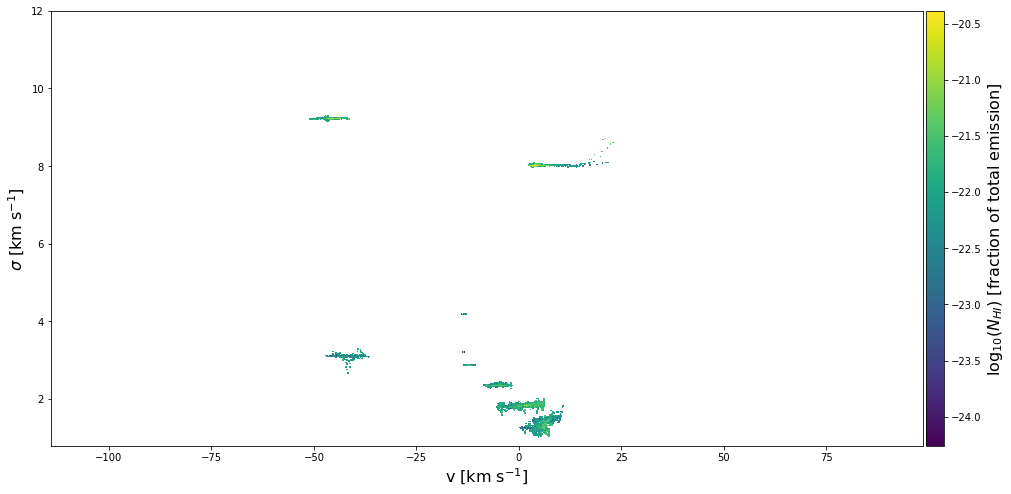

In [97]:
#HEATMAP 
x_bins = np.linspace(np.min(params[1::3].ravel()), np.max(params[1::3].ravel()), 1200)
y_bins = np.linspace(0.8,12., 1200)
H, xedges, yedges = np.histogram2d(params[1::3].ravel(), params[2::3].ravel(),
                                   weights=np.sqrt(2.*np.pi)*params[0::3].ravel()*(params[2::3].ravel())*C/1.e18/np.sum(field),
                                   bins=[x_bins, y_bins])
H = np.ma.masked_invalid(np.atleast_2d(H))
fig = plt.figure(figsize=(16.,8.))
ax = fig.add_subplot(111)
ax.set_ylim([0.8, 12.])
ax.set_xlim([np.min(params[1::3].ravel()),np.max(params[1::3].ravel())])
ax.set_xlabel(r'v [km s$^{-1}$]',  fontsize = 16)
ax.set_ylabel(r'$\sigma$ [km s$^{-1}$]',  fontsize = 16)
ax.yaxis.set_major_formatter(ScalarFormatter())
divider = make_axes_locatable(ax)
cax = divider.append_axes('right', size='2%', pad=0.05)
im = ax.pcolormesh(xedges, yedges, np.log10(H.T), cmap="viridis")
cbar = fig.colorbar(im, cax=cax, orientation='vertical')
cbar.set_label(r'log$_{10}$($N_{HI}$) [fraction of total emission]', fontsize = 16)
fig.savefig("2D_Histogram_heat_map_galaxy", bbox_inches="tight")

## Plot mosaics of the maps (column density, velocity, and dispersion)

Column Density maps:

<Figure size 432x288 with 0 Axes>

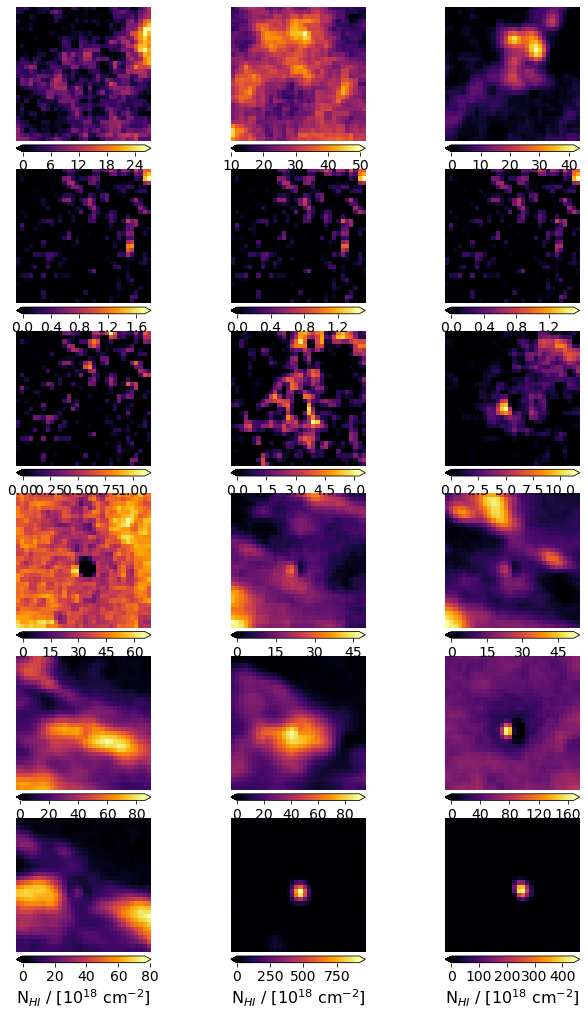

In [98]:
def cm2inch(*tupl):
        inch = 2.54
        if isinstance(tupl[0], tuple):
            return tuple(i/inch for i in tupl[0])
        else:
            return tuple(i/inch for i in tupl)
        
iddx = np.argsort(np.mean(position_galaxy, axis=(1,2)))
field = [NHI_map_galaxy[idd] for idd in iddx]
vfield = [position_galaxy[idd] for idd in iddx]
ampfield = [amplitude_galaxy[idd] for idd in iddx]
sigfield = [dispersion_galaxy[idd] for idd in iddx]
        
#Plot mosaic field 
fig=plt.figure()
lh = 6; lw = 3
fig, axs = plt.subplots(lh, lw, sharex=True, sharey=True, figsize=(cm2inch((22.,35.5))))
fig.subplots_adjust(top=1., bottom=0.05, left=0., right=1., hspace=0.12, wspace=0.1)
k = 0
for i in np.arange(lh):
    for j in np.arange(lw):
        im = axs[i][j].imshow(field[k]/10**18, origin="lower", cmap="inferno")
        if j == 0: axs[i][j].set_ylabel(r'y')
        axs[i][j].set_xlabel(r'x')
        axs[i][j].axes.xaxis.set_ticklabels([])
        axs[i][j].axis('off')
        divider = make_axes_locatable(axs[i][j])
        cax = divider.append_axes('bottom', size='5%', pad=0.05)
        cbar = fig.colorbar(im, cax=cax, orientation='horizontal', extend="both")
        tick_locator = ticker.MaxNLocator(nbins=5)
        cbar.locator = tick_locator
        cbar.update_ticks()
        cbar.ax.tick_params(labelsize=14.)
        if i == lh-1 : cbar.set_label(r"N$_{HI}$ / [10$^{18}$ cm$^{-2}$]", fontsize=16.)
        k += 1
fig.savefig("Column_Density_galaxy.pdf", bbox_inches="tight")
# plt.axis('off')
#plt.savefig('plot/mosaic_field.pdf', format='pdf')

Velocity maps:

<Figure size 432x288 with 0 Axes>

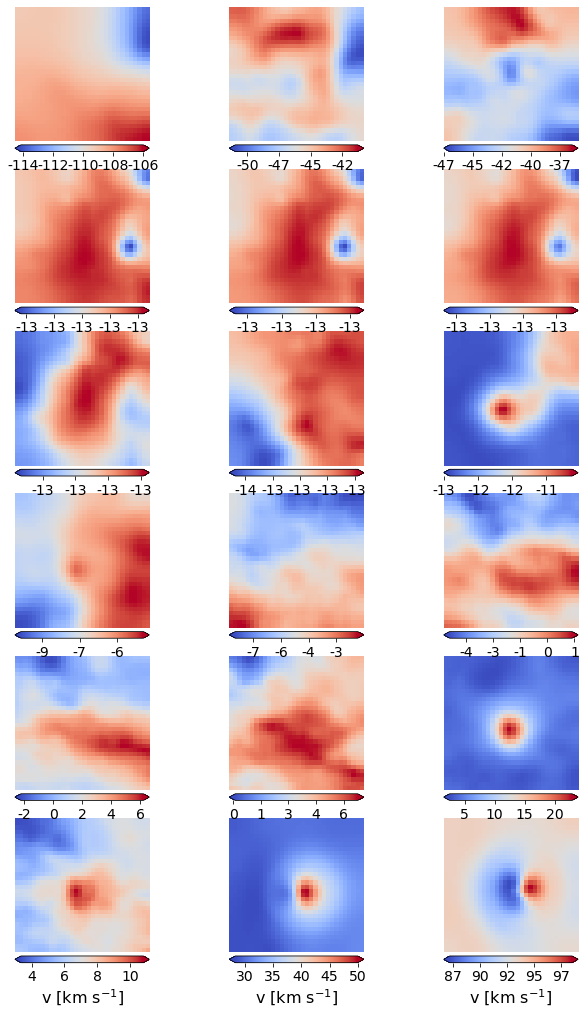

In [99]:
#Plot mosaic field mean
fig=plt.figure()
lh = 6; lw = 3
fig, axs = plt.subplots(lh, lw, sharex=True, sharey=True, figsize=(cm2inch((22.,35.5))))
fig.subplots_adjust(top=1., bottom=0.05, left=0., right=1., hspace=0.12, wspace=0.1)
k = 0
for i in np.arange(lh):
    for j in np.arange(lw):
        elev_min=np.nanmin(vfield[k])
        elev_max=np.nanmax(vfield[k])
        mid_val=0
        im1 = axs[i][j].imshow(vfield[k], origin="lower", cmap="coolwarm")
        if j == 0: axs[i][j].set_ylabel(r'y')
        axs[i][j].set_xlabel(r'x')
        axs[i][j].axes.xaxis.set_ticklabels([])
        axs[i][j].axis('off')
        divider = make_axes_locatable(axs[i][j])
        cax = divider.append_axes('bottom', size='5%', pad=0.05)
        cbar = fig.colorbar(im1, cax=cax, orientation='horizontal', format='%d', extend="both")
        tick_locator = ticker.MaxNLocator(nbins=5)
        cbar.locator = tick_locator
        cbar.update_ticks()
        cbar.ax.tick_params(labelsize=14.)
        if i == lh-1 : cbar.set_label(r"v [km s$^{-1}$]", fontsize=16.)
        k += 1
fig.savefig("Velocity_galaxy.pdf", bbox_inches="tight")
# plt.axis('off')                                                                                                                                                                                                                                                                                                          
#plt.savefig('plot/mosaic_vfield.pdf', format='pdf')

Velocity Dispersion maps:

<Figure size 432x288 with 0 Axes>

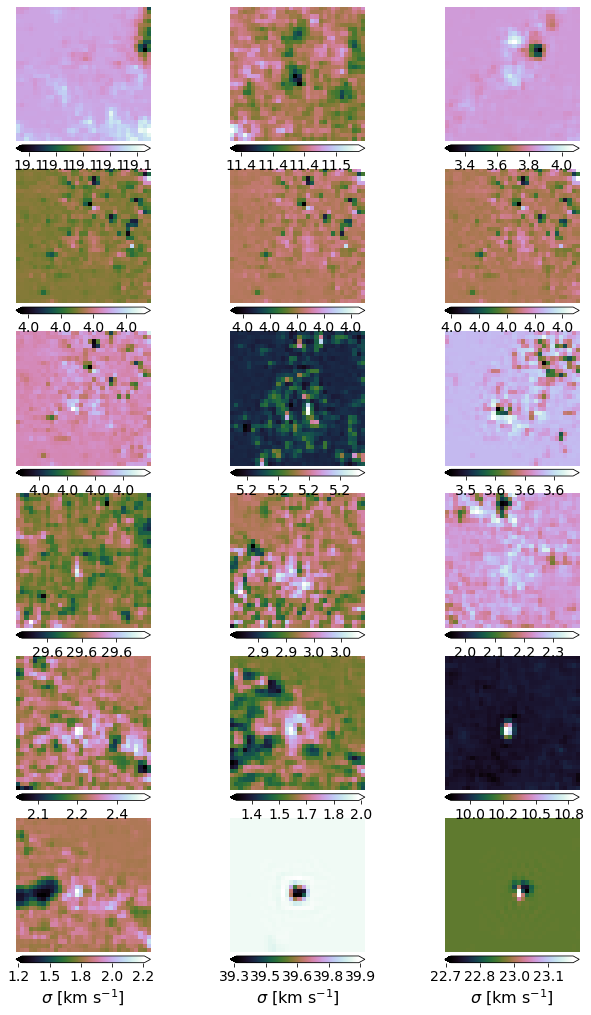

In [100]:
#Plot mosaic field sigma  
fig=plt.figure()
lh = 6; lw = 3
fig, axs = plt.subplots(lh, lw, sharex=True, sharey=True, figsize=(cm2inch((22.,35.5))))
fig.subplots_adjust(top=1., bottom=0.05, left=0., right=1., hspace=0.12, wspace=0.1)
k = 0
for i in np.arange(lh):
    for j in np.arange(lw):
        im1 = axs[i][j].imshow(sigfield[k], origin="lower", cmap="cubehelix")
        if j == 0: axs[i][j].set_ylabel(r'y')
        axs[i][j].set_xlabel(r'x')
        axs[i][j].axes.xaxis.set_ticklabels([])
        axs[i][j].axis('off')
        divider = make_axes_locatable(axs[i][j])
        cax = divider.append_axes('bottom', size='5%', pad=0.05)
        cbar = fig.colorbar(im1, cax=cax, orientation='horizontal', format='%.1f', extend="both")
        tick_locator = ticker.MaxNLocator(nbins=5)
        cbar.locator = tick_locator
        cbar.update_ticks()
        cbar.ax.tick_params(labelsize=14.)
        if i == lh-1 : cbar.set_label(r"$\sigma$ [km s$^{-1}$]", fontsize=16.)
        k += 1
        
fig.savefig("Velocity_Dispersion_galaxy.pdf", bbox_inches="tight")
# plt.axis('off')                                                                                                                                                                                                                                                                                                          
#plt.savefig('plot/mosaic_sigfield.pdf', format='pdf')

## Plot a residual map

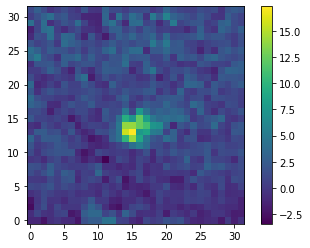

In [101]:
# Find the residual map
fig=plt.figure()
mdl_galaxy = np.sum(model_galaxy , 0)
dat_galaxy = np.sum(subcube_galaxy, 0)

plt.imshow(mdl_galaxy - dat_galaxy, origin="lower")
plt.colorbar()
fig.savefig("residual_map_galaxy.pdf", bbox_inches="tight")

From this residual map, we can see that is very flat all around the point source, however, the point source it self is not well fit by the model.

## Plot a unique pixel

The brightest spot can be plotted too.

In [37]:
x_pos_galaxy = 15 ; y_pos_galaxy = 14

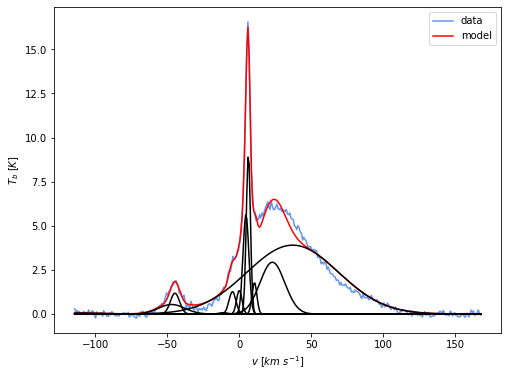

In [102]:
plot_spect(x_pos_galaxy, y_pos_galaxy, subvel_galaxy,\
           model_galaxy[:, y_pos_galaxy, x_pos_galaxy], subcube_galaxy[:, y_pos_galaxy, x_pos_galaxy],\
           gaussian_galaxy, "Central_pixel_of_Galaxy_spectrum.pdf")
